# Laboratorio 4 - Data Science
## Integrantes:
### Mario Guerra - 21008
### Javier Alvarado - 21188

## Análisis Exploratorio

In [1]:
#!pip install numpy pandas matplotlib seaborn tensorflow


  Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.2.1-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp311-cp311-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorflow_intel-2.17.0-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  

In [1]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import numpy as np
import seaborn as sns

from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import ops

In [2]:
def load_data(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                image = load_img(file_path, color_mode='grayscale')
                image = img_to_array(image)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Cargar datos de entrenamiento y prueba
train_dir = 'PolyMNIST/MMNIST/train'
test_dir = 'PolyMNIST/MMNIST/test'

train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

print(f'Train Images Shape: {train_images.shape}')
print(f'Train Labels Shape: {train_labels.shape}')
print(f'Test Images Shape: {test_images.shape}')
print(f'Test Labels Shape: {test_labels.shape}')


Train Images Shape: (300000, 28, 28, 1)
Train Labels Shape: (300000,)
Test Images Shape: (50000, 28, 28, 1)
Test Labels Shape: (50000,)


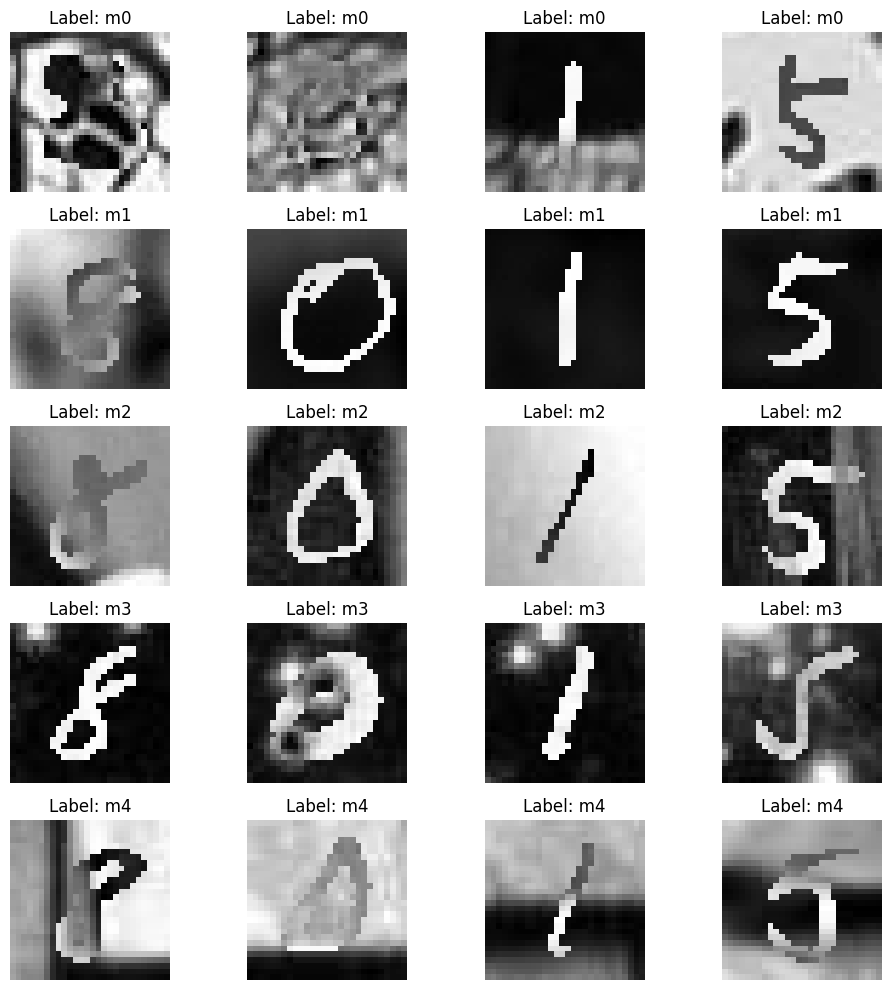

In [3]:
# Convertir etiquetas y datos a un DataFrame para filtrar por cada clase
train_df = pd.DataFrame({'image': list(train_images), 'label': train_labels})

# Mostrar algunas imágenes del dataset de entrenamiento para las etiquetas m1, m2, m3, y m4
plt.figure(figsize=(10, 10))

for i, label in enumerate(['m0', 'm1', 'm2', 'm3', 'm4']):
    # Filtrar imágenes por etiqueta
    filtered_df = train_df[train_df['label'] == label].sample(4, random_state=42)
    
    for j, img in enumerate(filtered_df['image']):
        plt.subplot(5, 4, i * 4 + j + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

plt.tight_layout()
plt.show()

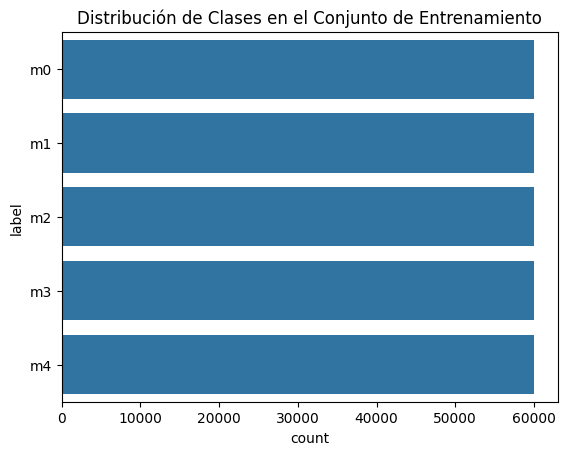

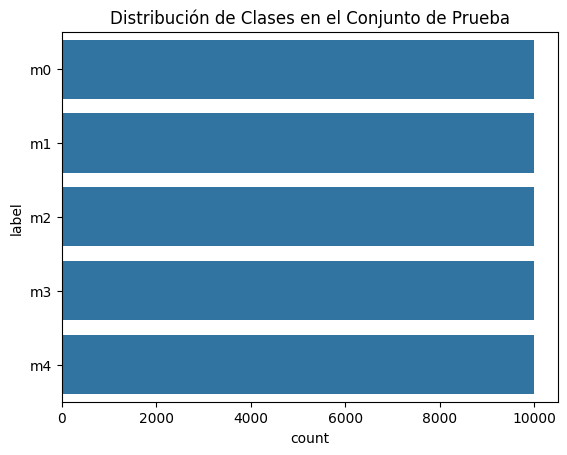

In [4]:
# Convertir etiquetas a DataFrame para facilitar la visualización
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Visualizar la distribución de las clases
sns.countplot(train_labels_df['label'])
plt.title("Distribución de Clases en el Conjunto de Entrenamiento")
plt.show()

# Visualizar la distribución de las clases
sns.countplot(test_labels_df['label'])
plt.title("Distribución de Clases en el Conjunto de Prueba")
plt.show()


In [5]:
# Verificar la resolución de las imágenes
resolution = train_images[0].shape
print(f'Resolución de las Imágenes: {resolution[0]}x{resolution[1]} píxeles')


Resolución de las Imágenes: 28x28 píxeles


In [6]:
# Contar la cantidad de cada etiqueta
train_class_distribution = train_labels_df['label'].value_counts().to_dict()
test_class_distribution = test_labels_df['label'].value_counts().to_dict()
print(f'Distribución de Clases: {test_class_distribution}')
print(f'Distribución de Clases: {test_class_distribution}')


Distribución de Clases: {'m0': 10000, 'm1': 10000, 'm2': 10000, 'm3': 10000, 'm4': 10000}
Distribución de Clases: {'m0': 10000, 'm1': 10000, 'm2': 10000, 'm3': 10000, 'm4': 10000}


## Creación de modelos de Deep Learning (CNN)

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalizar imágenes
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Codificar etiquetas a números
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convertir etiquetas a one-hot encoding
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)


# Modelo 1: CNN Básico

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_basic_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

basic_cnn = create_basic_cnn()


c:\Users\Kristopher\Documents\S8\Data Science\Lab4DataScience\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Modelo 2: CNN Avanzado

In [ ]:
from tensorflow.keras.layers import Dropout

def create_advanced_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

advanced_cnn = create_advanced_cnn()